In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets
import glob

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ks1mo348 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_closure():
    plt.show()
    plt.close()

# Dataset

In [3]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [4]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)

start_points = all_points[:,0,1:]
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
std of:  0.17514298792733465
shape before reducing dimension (155, 64, 8)
dataset variance of: [5.97890823e-05 3.85856730e-05 4.10100488e-05 8.16263167e-03
 3.06750662e-02 7.01886397e-03 7.93129919e-03]


In [5]:
def scale_dataset(input_points):
    points = input_points - mean
    poss = position_scaling
    rts = rotation_scaling
    points = (points * np.array((poss,poss,poss,rts,rts,rts,rts)))
    return points
    
def unscale_dataset(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean
    return points

In [6]:
dataset = scale_dataset(start_points)
dataset

array([[ 0.04595317, -0.05441428, -0.01690089, ...,  0.05443873,
         0.03846967,  0.04641757],
       [-0.0741912 , -0.01686631, -0.02128294, ..., -0.05807739,
        -0.04147228, -0.07553821],
       [ 0.01013517, -0.02150781, -0.03167534, ...,  0.0575545 ,
         0.0088552 ,  0.04299195],
       ...,
       [-0.01898356,  0.01555381, -0.01404171, ..., -0.08089616,
        -0.04851974,  0.05299186],
       [-0.03843893,  0.02241283,  0.00362743, ..., -0.24245387,
        -0.07568732,  0.03212889],
       [ 0.01442239, -0.00144738, -0.00559424, ...,  0.21880809,
         0.10839383,  0.05271387]])

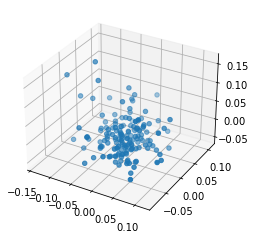

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);

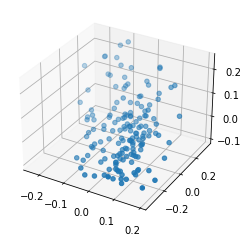

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);

## 2D VAE Fit to Dataset

In [9]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [10]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [11]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [12]:
testname = "const_delta_higher_curv_samp/annealeps"

In [13]:
all_models = []

for beta in [0.00001,0.01,0.001,0.0001]:
    for lr in [0.0005,0.0001]:
        for curvreg in [0]:#,0.0001,0.0002,0.0004,0.0008,0.001]:#,1,10,100,1000]:
            secreg = 0
            for latentdim in [2]:
                for epsilon_scale_start in [0.5,1]:
                    try:
                        savedir_pattern  = savedir  = f'{testname}lat{latentdim}_lr{lr}_curvreg{curvreg}_es{epsilon_scale_start}_beta{beta}_*'

                        filenames = glob.glob(savedir_pattern)
                        #print(len(filenames))
                        for filename in filenames:
                            try:
                                #print(filename)
                                textfilename = glob.glob(filename + "/model_type.txt")[0]
                                #print(textfilename)
                                all_models.append(filename)
                            except:
                                continue
                    except:
                        continue

In [14]:

all_models

['const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta1e-05_20220208-160220',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta1e-05_20220208-163954',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.01_20220208-163030',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta0.01_20220208-170805',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta0.001_20220208-165841',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.0001_20220208-161142',
 'const_delta_higher_curv_samp/annealepslat2_lr0.0001_curvreg0_es1_beta0.0001_20220208-164919']

In [15]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [16]:
def make_2d_grid_points(xmin, xmax, ymin, ymax, ):
    #lim = 6
    num_few = 7
    num_many = 1000
    pts = []
    for x in np.linspace(xmin, xmax, num_few):
        for y in np.linspace(ymin, ymax, num_many):
                pts.append((x,y))
    for y in np.linspace(ymin, ymax, num_few):
        for x in np.linspace(xmin, xmax, num_many):
                pts.append((x,y))
    return np.array(pts)

In [17]:
def twodcolormap(pt, minval=-3, maxval=3):
    scaled_pt = (pt - minval)/(maxval-minval)
    cs = (scaled_pt[:,:1] * np.array((1,0,-1)).reshape(1,3) + 
          scaled_pt[:,1:2] * np.array((0,1,0)).reshape(1,3) + 
          np.array((0,0,1)).reshape(1,3))
    return cs

In [18]:
def get_scale(data, buffer=0.1):
    valrange = np.max(data) - np.min(data)
    return(np.min(data)-buffer*valrange,np.max(data)+buffer*valrange,)

In [19]:
latent_1_scale = (-3,3)
latent_2_scale = (-3,3)

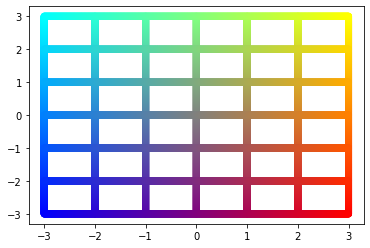

In [20]:
z1min, z1max = latent_1_scale
z2min, z2max = latent_2_scale
pts = make_2d_grid_points(z1min, z1max, z2min, z2max)
colorsofpoints = twodcolormap(pts)
plt.scatter(pts[:,0],pts[:,1],c=colorsofpoints)

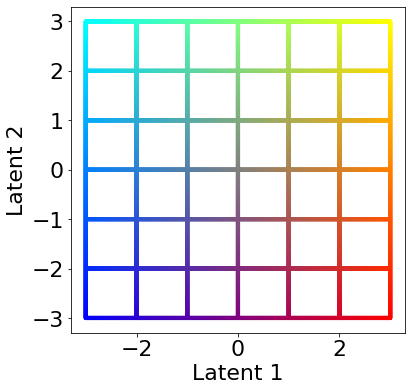

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950


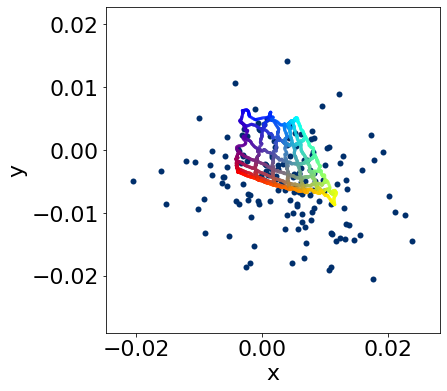

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950


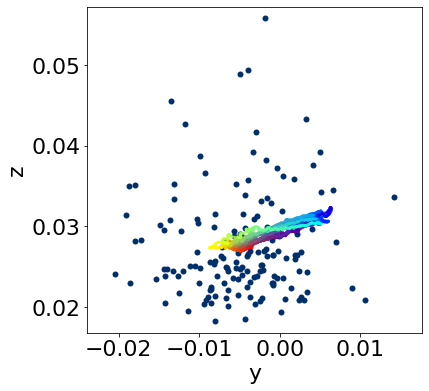

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950


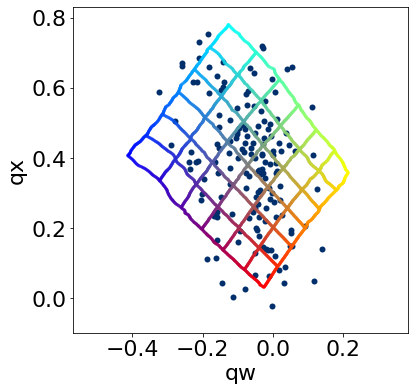

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950


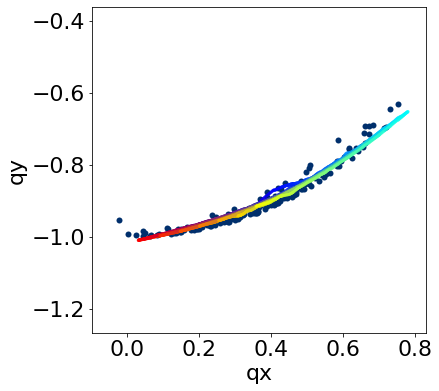

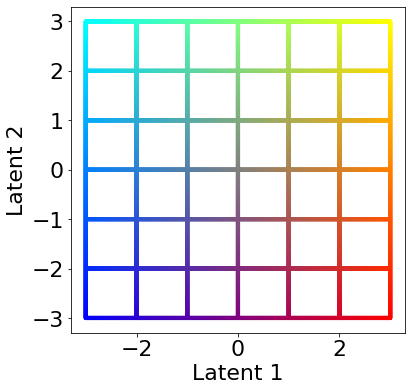

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107


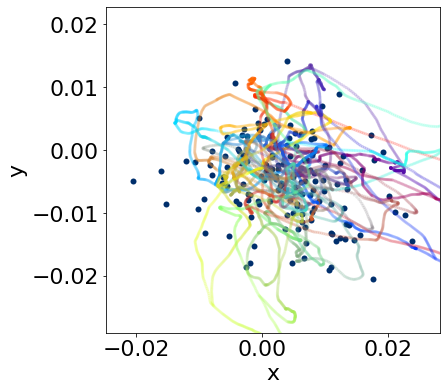

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107


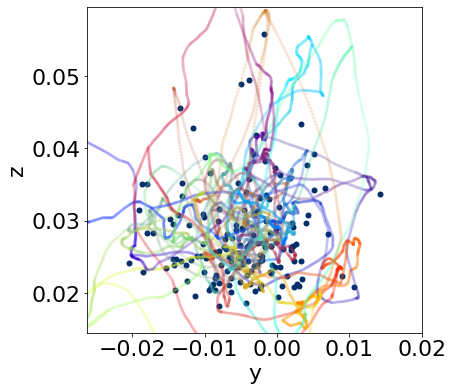

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107


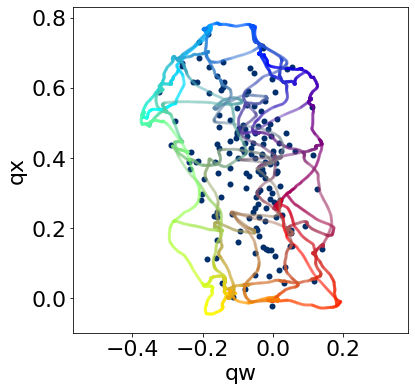

const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107


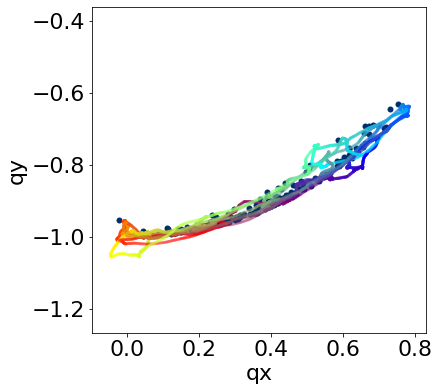

In [21]:
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)
axis_names = ["x","y","z","qw","qx","qy","qz"]
blue = np.array([[0,47,108]])/255
red = np.array([[170,20,45]])/255

all_models = [#('const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta1e-05_20220208-160220', 'vae'),
             ('const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950', 'curvvae'),
              ('const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta0.001_20220208-162107', 'vae')
             ]
for modelpath, modelname in all_models:
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    #z1min, z1max = get_scale(embeds[:,0], -0.05)
    #z2min, z2max = get_scale(embeds[:,1], -0.05)
    z1min, z1max = latent_1_scale
    z2min, z2max = latent_2_scale
    pts = make_2d_grid_points(z1min, z1max, z2min, z2max)
    colorsofpoints = twodcolormap(pts)
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()

    readout = unscale_dataset(readout)
    f, axs = plt.subplots(1,1,figsize=(6,6))#,subplot_kw={'projection':'3d'})
    axs.scatter(pts[:,0], pts[:,1], c=colorsofpoints,s=10)
    axs.set_xlabel("Latent 1")
    axs.set_ylabel("Latent 2")
    f.savefig(f"images/initial_pose_fit_{modelname}_latent.png",
          bbox_inches = 'tight')
    plot_closure()
    
    for inds in [[0,1],[1,2],[3,4],[4,5]]:
        print(modelpath)
        f, axs = plt.subplots(1,1,figsize=(6,6))#,subplot_kw={'projection':'3d'})
        axs.scatter(start_points[:,inds[0]],start_points[:,inds[1]], alpha=1,linewidths=0,c=blue);
        axs.scatter(readout[:,inds[0]],readout[:,inds[1]], alpha=0.2,linewidths=0,s=10,c=colorsofpoints);
        axs.axis('equal')
        axs.set(xlim=get_scale(start_points[:,inds[0]]), ylim=get_scale(start_points[:,inds[1]]))
        axs.set_xlabel(axis_names[inds[0]])
        axs.set_ylabel(axis_names[inds[1]])
        f.savefig(f"images/initial_pose_fit_{modelname}_{axis_names[inds[0]]}_{axis_names[inds[1]]}.png",
                  bbox_inches = 'tight')
        plot_closure()